# Analysing the dataset


### File Structure:
- **Port_IDs**: This column contains a unique identifier for the portfolio.
- **Trade_History**: This column contains a list of trade records, where each record is a dictionary with details about a specific trade.

### Trade Record Details:
Each trade record in the `Trade_History` column contains the following fields:
- **time**: The timestamp of the trade in milliseconds.
- **symbol**: The trading pair (e.g., SOLUSDT, DOGEUSDT, FILUSDT, etc.).
- **side**: The side of the trade, either "BUY" or "SELL".
- **price**: The price at which the trade was executed.
- **fee**: The fee incurred for the trade, usually in USDT.
- **feeAsset**: The asset in which the fee was paid (usually USDT).
- **quantity**: The total quantity of the trade in the quote asset (usually USDT).
- **quantityAsset**: The asset in which the quantity is denominated (usually USDT).
- **realizedProfit**: The profit or loss realized from the trade, if any.
- **realizedProfitAsset**: The asset in which the profit or loss is denominated (usually USDT).
- **baseAsset**: The base asset being traded (e.g., SOL, DOGE, FIL, etc.).
- **qty**: The quantity of the base asset traded.
- **positionSide**: The position side, either "LONG" or "SHORT".
- **activeBuy**: A boolean indicating whether the trade was an active buy (True or False).

### Example Trade Record:
```json
{
  "time": 1718899656000,
  "symbol": "SOLUSDT",
  "side": "BUY",
  "price": 132.537,
  "fee": -0.9940275,
  "feeAsset": "USDT",
  "quantity": 1988.055,
  "quantityAsset": "USDT",
  "realizedProfit": 0.0,
  "realizedProfitAsset": "USDT",
  "baseAsset": "SOL",
  "qty": 15.0,
  "positionSide": "LONG",
  "activeBuy": true
}
```
This record indicates that a BUY order was executed for 15 SOL at a price of 132.537 USDT per SOL, with a fee of 0.9940275 USDT. The trade was part of a LONG position.

### Observations:
- The trades involve various cryptocurrencies like SOL, DOGE, FIL, ETC, BCH, BTC, ETH, and BNB.
- The trades are both BUY and SELL orders, with some trades resulting in realized profits or losses.
- The fees are typically in USDT, and the trades are denominated in USDT as well.
- The `realizedProfit` field indicates whether the trade resulted in a profit or loss, and the `realizedProfitAsset` is usually USDT.



## Importing libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import ast
import numpy as np

## Loading the dataset

In [2]:
df = pd.read_csv('TRADES_CopyTr_90D_ROI.csv')

def safe_eval(value):
    try:
        return ast.literal_eval(value) 
    except (ValueError, SyntaxError):
        return None  # Handle invalid entries

# Apply the function to the Trade_History column
df['Trade_History'] = df['Trade_History'].apply(safe_eval)
df['Port_IDs'] = df['Port_IDs'].astype(str)

df = df.dropna(subset=['Trade_History'])


### Basic Visualiations

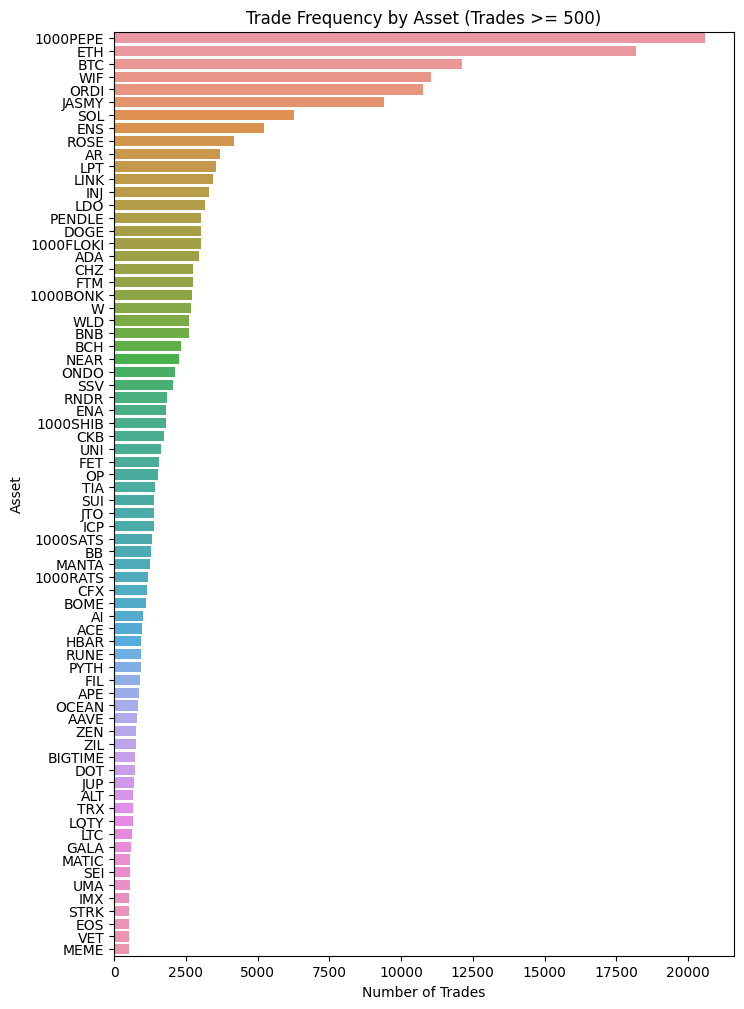

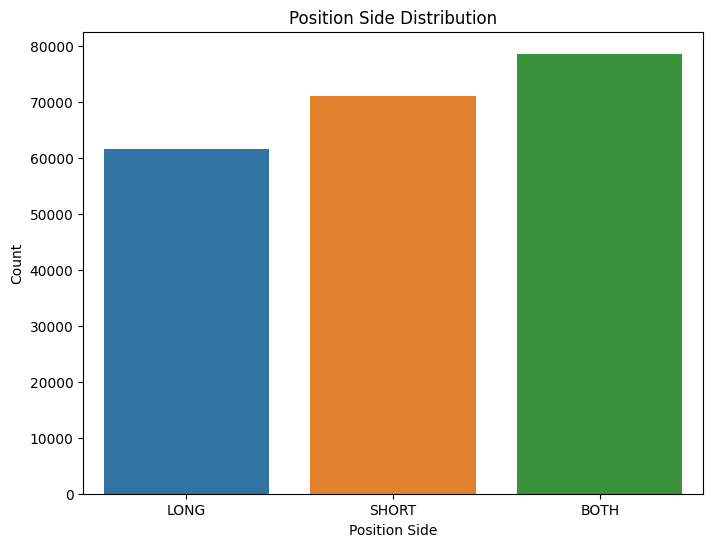

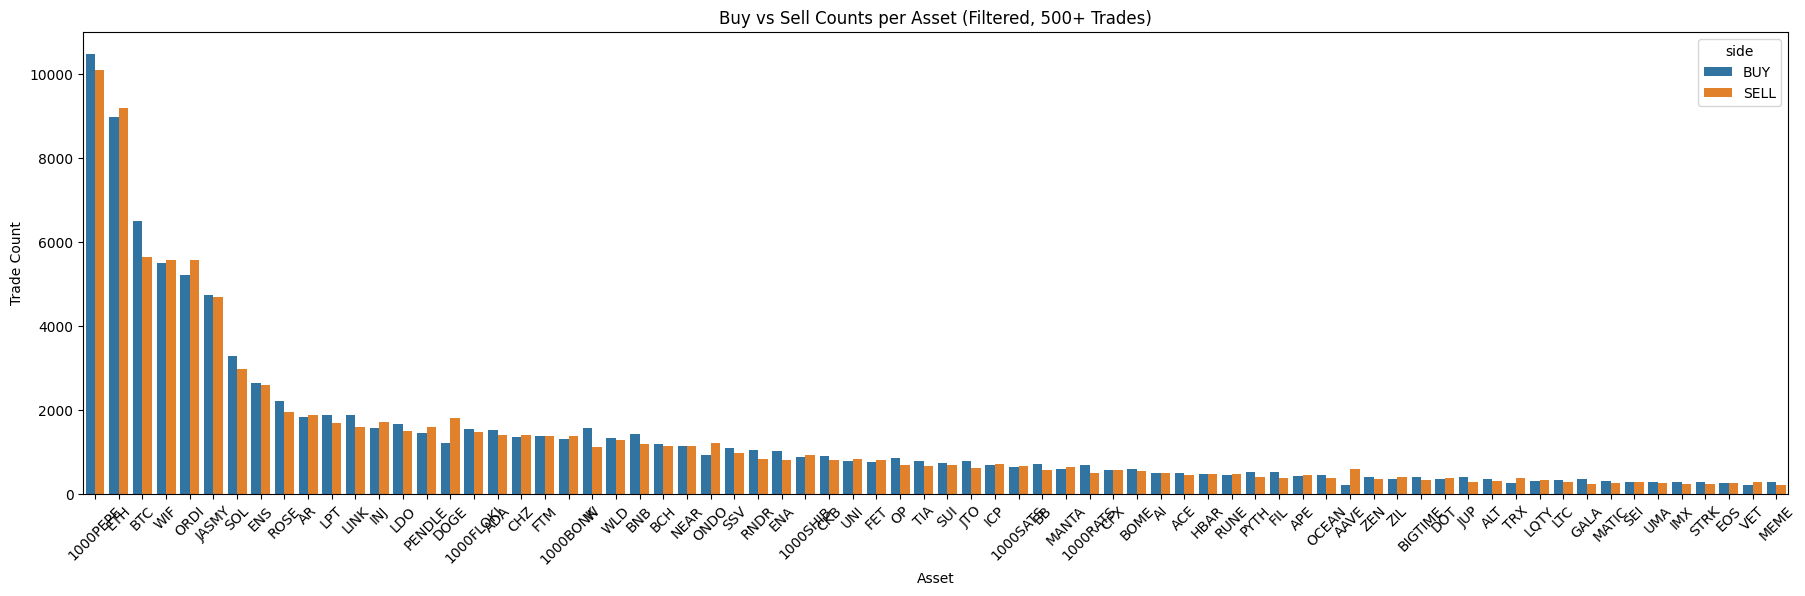

In [3]:
trade_records = pd.DataFrame([trade for trades in df['Trade_History'] for trade in trades])

# Filter out assets with fewer than 500 trades
asset_trade_counts = trade_records['baseAsset'].value_counts()
frequent_assets = asset_trade_counts[asset_trade_counts >= 500].index

filtered_trades = trade_records[trade_records['baseAsset'].isin(frequent_assets)]

# Visualization 1
plt.figure(figsize=(8, 12))
sns.countplot(y='baseAsset', data=filtered_trades, order=filtered_trades['baseAsset'].value_counts().index)
plt.title('Trade Frequency by Asset (Trades >= 500)')
plt.xlabel('Number of Trades')
plt.ylabel('Asset')
plt.show()

# Visualization 2
plt.figure(figsize=(8, 6))
sns.countplot(x='positionSide', data=trade_records)
plt.title('Position Side Distribution')
plt.xlabel('Position Side')
plt.ylabel('Count')
plt.show()

# Visualization 3
plt.figure(figsize=(22, 6))
sns.countplot(
    data=filtered_trades, 
    x='baseAsset', 
    hue='side', 
    order=filtered_trades['baseAsset'].value_counts().index
)
plt.title('Buy vs Sell Counts per Asset (Filtered, 500+ Trades)')
plt.xlabel('Asset')
plt.ylabel('Trade Count')
plt.xticks(rotation=45)
plt.show()

### Metrics to Calculate:

**ROI (Return on Investment)**

**PnL (Profit and Loss)**

**Sharpe Ratio**

**MDD (Maximum Drawdown)**

**Win Rate**

**Win Positions**

**Total Positions**


In [9]:
def calculate_metrics(trade_history):
    trades = pd.DataFrame(trade_history)
    
    # Calculate PnL (Profit and Loss)
    pnl = trades['realizedProfit'].sum()
    
    # Calculate ROI (Return on Investment)
    total_investment = trades[trades['side'] == 'BUY']['quantity'].sum()
    roi = (pnl / total_investment) * 100 if total_investment != 0 else 0
    
    # Calculate Win Rate and Win Positions
    win_positions = trades[trades['realizedProfit'] > 0].shape[0]
    total_positions = trades.shape[0]
    win_rate = (win_positions / total_positions) * 100 if total_positions != 0 else 0
    
    # Calculate Sharpe Ratio (assuming risk-free rate = 0)
    returns = trades['realizedProfit'] / trades['quantity']
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0
    
    # Calculate Maximum Drawdown (MDD)
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    mdd = drawdown.min()
    
    return {
        'ROI': roi,
        'PnL': pnl,
        'Sharpe Ratio': sharpe_ratio,
        'MDD': mdd,
        'Win Rate': win_rate,
        'Win Positions': win_positions,
        'Total Positions': total_positions
    }

metrics = df['Trade_History'].apply(calculate_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

result_df = pd.concat([df['Port_IDs'], metrics_df], axis=1)





### Weighted Scores

In [10]:
weights = {
    'ROI': 0.3,
    'PnL': 0.25,
    'Sharpe Ratio': 0.2,
    'MDD': 0.15,
    'Win Rate': 0.1
}

### Normalizaing Metrics and creating Top 20 accounts CSV

In [11]:

# Normalize metrics
normalized_df = result_df.copy()
for col in weights.keys():
    normalized_df[col] = (result_df[col] - result_df[col].min()) / (result_df[col].max() - result_df[col].min())

# Calculate weighted score
normalized_df['Score'] = sum(normalized_df[col] * weight for col, weight in weights.items())

# Rank accounts
normalized_df['Rank'] = normalized_df['Score'].rank(ascending=False)

top_20_accounts = normalized_df.sort_values(by='Rank').head(20)
top_20_accounts.to_csv('top_20_accounts.csv', index=False)

### Creating Report

In [13]:

report = f"""
Analysis Report:

1. **Objective**:
   The objective of this analysis is to evaluate the performance of various Binance accounts over a 90-day period based on their trade history. The accounts are ranked using a weighted scoring system that incorporates key financial metrics such as ROI, PnL, Sharpe Ratio, MDD, and Win Rate.

2. **Dataset Overview**:
   - The dataset contains historical trade data for multiple Binance accounts.
   - Each account is identified by a unique `Port_ID`.
   - The `Trade_History` column contains detailed information about each trade, including timestamp, asset, side (BUY/SELL), price, quantity, and realized profit.

3. **Data Cleaning and Preparation**:
   - The `Trade_History` column was initially in string format and was converted to a list of dictionaries using `ast.literal_eval()` for safer parsing.
   - Invalid entries (e.g., malformed JSON or missing data) were identified and removed from the dataset to ensure data quality.
   - After cleaning, the dataset contained trade histories for {len(result_df)} accounts.

4. **Metrics Calculated**:
   The following financial metrics were calculated for each account:
   - **ROI (Return on Investment)**: Measures the percentage return on the total investment made by the account.
   - **PnL (Profit and Loss)**: The total profit or loss realized by the account over the 90-day period.
   - **Sharpe Ratio**: A risk-adjusted return metric that indicates the return per unit of risk (assuming a risk-free rate of 0).
   - **MDD (Maximum Drawdown)**: The maximum observed loss from a peak to a trough in the account's performance.
   - **Win Rate**: The percentage of trades that resulted in a profit.
   - **Win Positions**: The total number of profitable trades.
   - **Total Positions**: The total number of trades executed by the account.

5. **Ranking Methodology**:
   - Accounts were ranked based on a weighted scoring system. The weights assigned to each metric are as follows:
     - ROI: 30%
     - PnL: 25%
     - Sharpe Ratio: 20%
     - MDD: 15%
     - Win Rate: 10%
   - Each metric was normalized to ensure fair comparison across accounts.
   - A composite score was calculated for each account by summing the weighted normalized scores of all metrics.
   - Accounts were ranked in descending order of their composite scores.

6. **Top 20 Accounts**:
   - The top 20 accounts were identified based on their composite scores.
   - These accounts demonstrated the best overall performance across all metrics.
   - Detailed metrics for the top 20 accounts are provided in the accompanying CSV file (`top_20_accounts.csv`).

7. **Key Findings**:
   - The top-performing accounts consistently achieved high ROI and PnL while maintaining a favorable Sharpe Ratio and low MDD.
   - Accounts with a high Win Rate and a large number of Win Positions tended to rank higher, indicating the importance of consistent profitability.
   - Some accounts with high PnL but low Sharpe Ratio or high MDD were ranked lower due to their higher risk profiles.

8. **Assumptions and Limitations**:
   - The risk-free rate for the Sharpe Ratio calculation was assumed to be 0.
   - The weights assigned to the metrics are subjective and can be adjusted based on specific business requirements.
   - The analysis assumes that the dataset is complete and accurate. Any missing or invalid data was handled by dropping the corresponding rows.

9. **Deliverables**:
   - **CSV File**: `top_20_accounts.csv` contains the top 20 accounts along with their calculated metrics and composite scores.
   - **Text File**: This report provides a detailed explanation of the methodology, findings, and assumptions.

10. **Next Steps**:
   - Further analysis could include segmenting accounts based on trading strategies or asset classes.
   - The weights used for ranking can be fine-tuned based on additional business insights or stakeholder feedback.
   - Incorporating additional metrics, such as volatility or turnover ratio, could provide deeper insights into account performance.
"""

# Save report to a text file
with open('analysis_report.txt', 'w') as f:
    f.write(report)

# Display the report
print(report)


Analysis Report:

1. **Objective**:
   The objective of this analysis is to evaluate the performance of various Binance accounts over a 90-day period based on their trade history. The accounts are ranked using a weighted scoring system that incorporates key financial metrics such as ROI, PnL, Sharpe Ratio, MDD, and Win Rate.

2. **Dataset Overview**:
   - The dataset contains historical trade data for multiple Binance accounts.
   - Each account is identified by a unique `Port_ID`.
   - The `Trade_History` column contains detailed information about each trade, including timestamp, asset, side (BUY/SELL), price, quantity, and realized profit.

3. **Data Cleaning and Preparation**:
   - The `Trade_History` column was initially in string format and was converted to a list of dictionaries using `ast.literal_eval()` for safer parsing.
   - Invalid entries (e.g., malformed JSON or missing data) were identified and removed from the dataset to ensure data quality.
   - After cleaning, the dat